<a href="https://colab.research.google.com/github/MartinaJoergensen/FirstCodes/blob/master/28_11_25ExamAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)

rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-11-27 11:15:28--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 137.138.120.151, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M   403KB/s    in 13m 4s  

2025-11-27 11:28:32 (198 KB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)
print(labels)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8
[0 0 0 ... 9 9 9]


In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


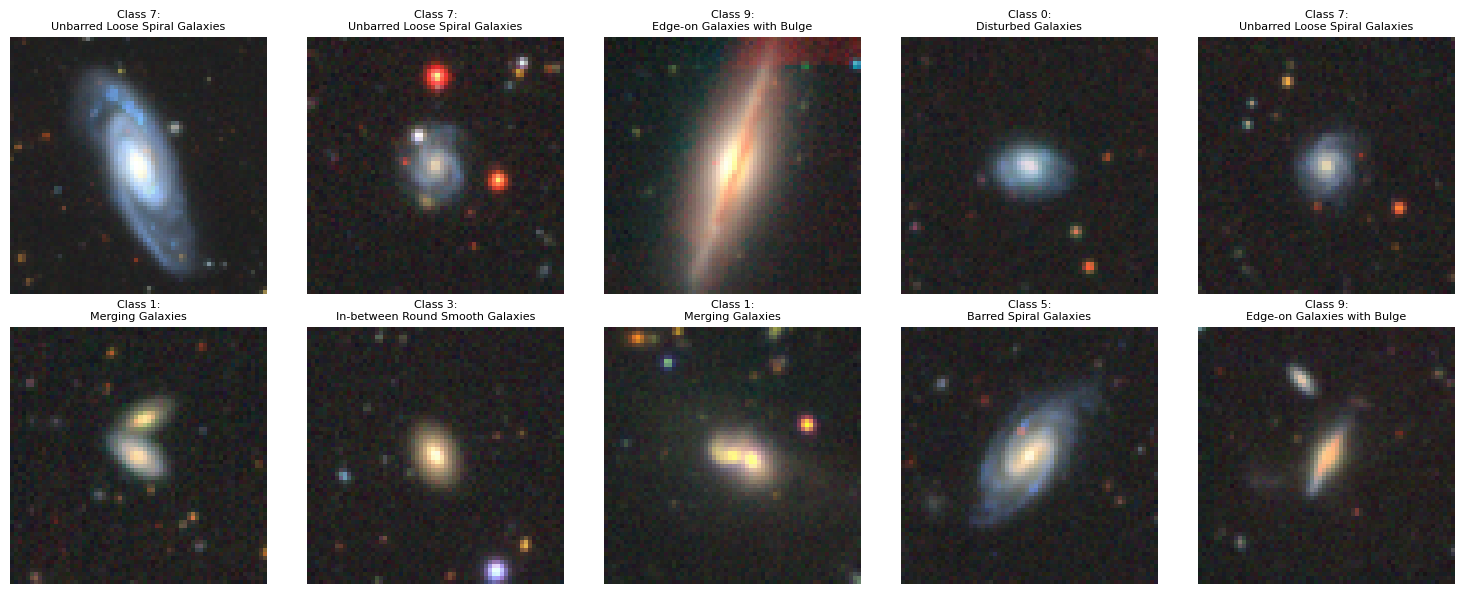

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 4

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 4, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (17402, 64, 64, 3)
Anomaly images: (334, 64, 64, 3)


In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
x_train, x_temp, y_train, y_temp = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
x_val, x_test, y_val, y_test = train_test_split(
    x_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train standard:", x_train.shape, y_train.shape)
print("Val standard:  ", x_val.shape, y_val.shape)
print("Test standard: ", x_test.shape, y_test.shape)
del std_images, std_labels, x_temp, y_temp

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [ ]:
# 4. Define a CNN classifier
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test, 10)


# Build a simple CNN model
model = tf.keras.Sequential([
    ##### Kernelsize = 7,7;
    tf.keras.layers.Conv2D(128, (14, 14), input_shape=(64, 64, 3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.MaxPooling2D((3, 3)),
    #####
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #####
    tf.keras.layers.Flatten(), #flatten the output to make it one dimensional;
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        75,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 51, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,722 (3.92 MB)

 Trainable params: 1,027,466 (3.92 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [ ]:
# 5. Train the model (mini-batch)
# Train the model and store the history
history = model.fit(x_train, y_train_cat, epochs=2, validation_data=(x_val, y_val_cat))

Epoch 1/2
261/261 ━━━━━━━━━━━━━━━━━━━━ 254s 974ms/step - accuracy: 0.2386 - loss: 1.9143 - val_accuracy: 0.1736 - val_loss: 6.1974
Epoch 2/2
261/261 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.2565 - loss: 1.8646 - val_accuracy: 0.1772 - val_loss: 9.2080


131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.1681 - loss: 9.3970

Test accuracy: 0.1789


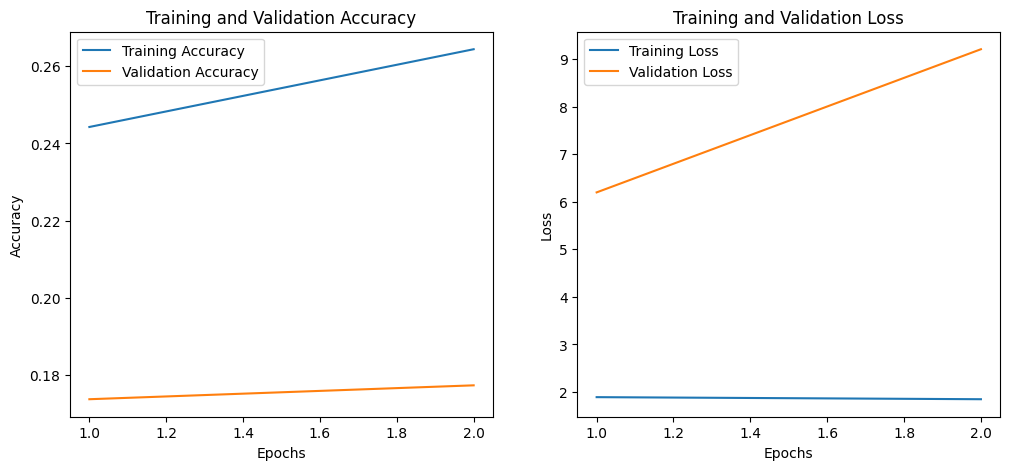

In [ ]:
# 6. Plot learning curves
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
# Convert y_test to one-hot encoding
y_test_cat = to_categorical(y_test, 10)

test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"\nTest accuracy: {test_acc:.4f}")


# Plot training history (accuracy and loss)
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


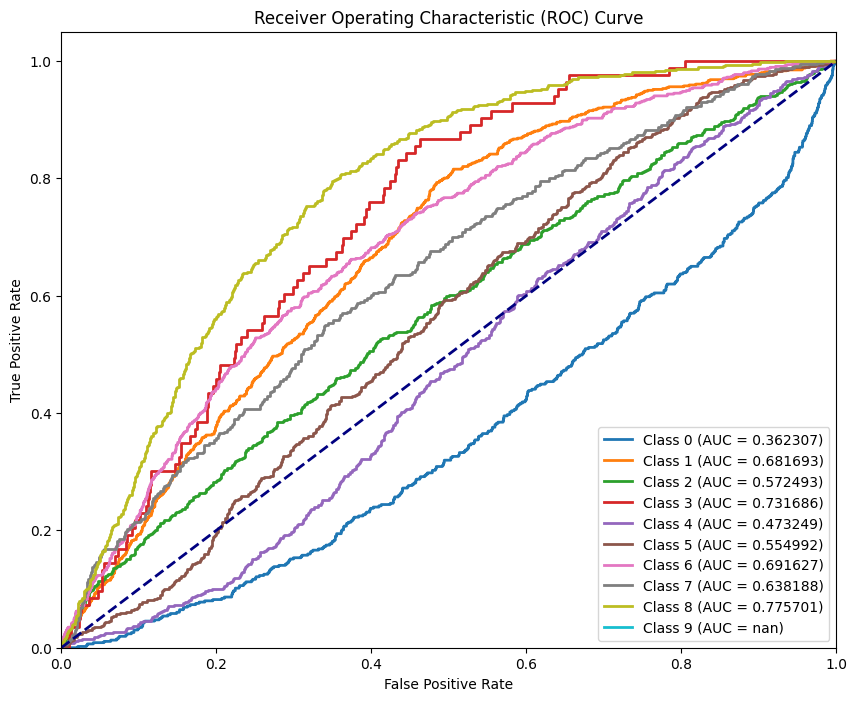

In [ ]:
# 7. ROC Curves (one-vs-all)
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_curve(x_test, y_test_cat, model)

131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step


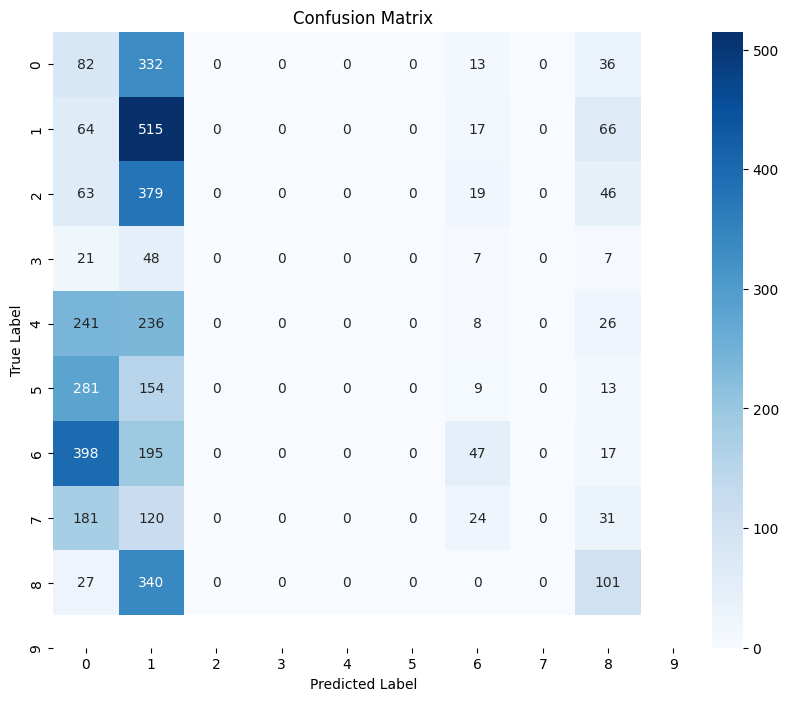

In [ ]:
# 8. Confusion Matrix
import seaborn as sns
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve & confusion matrix (adapt provided code)

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Dense, Reshape, BatchNormalization, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K


In [ ]:
# # Create anomaly dataset: all class 0 images
# ANOMALY_CLASS = 0

# anomaly_mask = (labels == ANOMALY_CLASS)
# standard_mask = ~anomaly_mask

# anom_images = images[anomaly_mask]
# anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

# std_images = images[standard_mask]
# std_labels_original = labels[standard_mask]

# print("Standard images:", std_images.shape)
# print("Anomaly images:", anom_images.shape)

x_normal = std_images
x_anomalies = anom_images

# Combine validation set with anomalies (label 0 for background, 1 for anomalies)
x_val = np.concatenate([x_val, x_anomalies], axis=0)
y_val = np.concatenate([np.zeros(len(x_val)), np.ones(len(x_anomalies))], axis=0)
# shuffle them if you want. Not really needed

In [ ]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # ----- Encoder -----
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # -> output shape (14, 14, 1)

    # bottleneck
    x = Flatten()(x)
    x = Dense(3, activation ='relu')(x) #3 nodes
    x = Dense(3, activation ='relu')(x)
    x = Dense(32 * 32 * 3, activation ='relu')(x) #i am getting a line
    x = Reshape((32,32,3))(x) #going back to an image

    # ----- Decoder -----
    x = UpSampling2D((2, 2))(x) #this is the opposite of Maxpooling2D; taking a pixel and making the same content of the pixel 4 times;
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) #Why sigmoid and relu? We have a binary decision; either 5 or not 5, so we can just use sigmoid;
    # -> output shape (28, 28, 1)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
# Build the autoencoder model
input_shape = (64, 64, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 1)      │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3072)           │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 1)      │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,431 (60.28 KB)

 Trainable params: 15,431 (60.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [ ]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the autoencoder on the training data
history2 = autoencoder.fit(x_train, x_train,
                          epochs=10,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val, x_val),#he is cheating by using it twice; gets fixed (14.10.2025)
                          callbacks=[early_stopping])

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - loss: 0.0956 - val_loss: 0.0209
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - loss: 0.0088 - val_loss: 0.0085


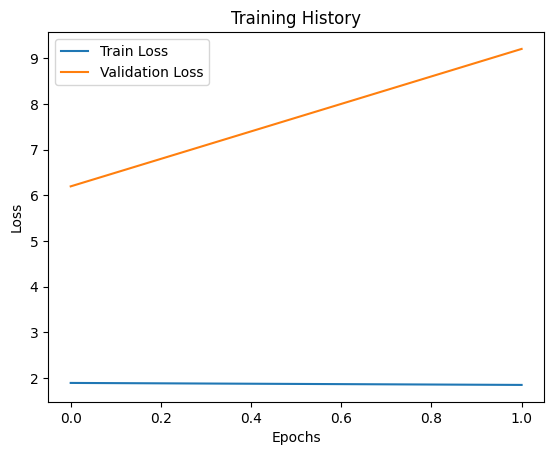

In [ ]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate MSE for the validation dataset
x_out_val = autoencoder.predict(x_val)
mse_val = np.mean(np.square(x_val - x_out_val), axis=(1, 2, 3))

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [ ]:
print(x_val.shape)

(4498, 64, 64, 3)


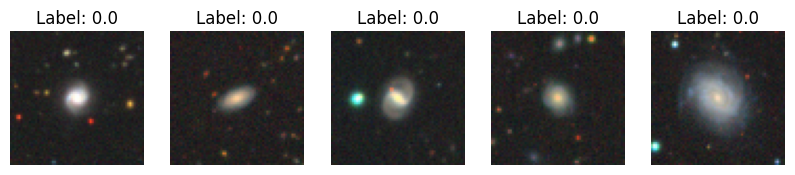

In [ ]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [i for i in range(9)]
for i, ax in enumerate(axes):
    ax.imshow(x_val[digits[i]])
    ax.set_title(f"Label: {y_val[digits[i]]}")
    ax.axis('off')
plt.show()

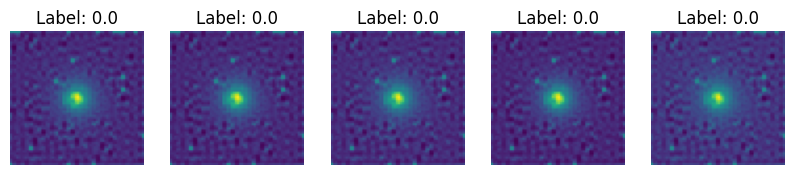

In [ ]:
# Visualize some digits from the output dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [i for i in range(9)]
for i, ax in enumerate(axes):
    ax.imshow(x_out_val[digits[i]])
    ax.set_title(f"Label: {y_val[digits[i]]}")
    ax.axis('off')
plt.show()

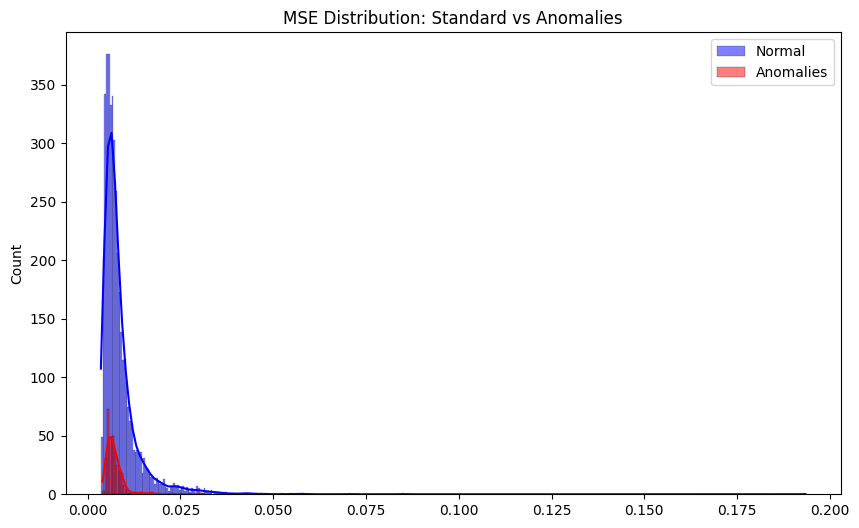

In [ ]:
import seaborn as sns
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))

# Correct y_val to match the length of mse_val
# The original x_val from train_test_split had 4164 samples (from 'Val standard:' output).
# x_anomalies has 334 samples.
# mse_val was computed on the combined x_val (4164 + 334 = 4498 samples).
# Therefore, the corresponding y_val should have 4164 zeros and 334 ones.
y_val_corrected = np.concatenate([np.zeros(4164), np.ones(len(x_anomalies))], axis=0)

sns.histplot(mse_val[y_val_corrected == 0], label='Normal', color='blue', kde=True)
sns.histplot(mse_val[y_val_corrected == 1], label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Standard vs Anomalies')
plt.legend()
plt.show()